In [1]:
import numpy as np
import ants

---
# TEST ONE

In [6]:
one = "/workspace/dwseon/dat/b4_raw/001/b4_reg_orig.nii.gz"
two = "/workspace/dwseon/dat/b4_raw/002/b4_reg_orig.nii.gz"

In [ ]:
img1 = ants.image_read(one)
img2 = ants.image_read(two)
# seg1 = ants.kmeans_segmentation(img1, 8)
ants.plot(img1, axis=2)
ants.plot(img2, axis=2)

In [8]:
aff = ants.registration(img1, img2, "Affine")
aff

In [10]:
g1 = ants.iMath_grad(img1)
g2 = ants.iMath_grad(img2)

In [ ]:
reg1 = ants.registration( img1, img2, 'SyNOnly',
                          initial_transform=aff['fwdtransforms'][0],
                          verbose=True)
# reg param 'moving_mask='
demonsMetric = ['demons', g1, g2, 1, 1]
ccMetric = ['CC', img1, img2, 1.5, 4]

In [ ]:
metrics = list()
metrics.append(demonsMetric)
reg2 = ants.registration(img1, img2, 'SyNOnly',
                         multivariate_extras=metrics, 
                         initial_transform=aff['fwdtransforms'][0],
                         verbose=True)

In [ ]:
metrics.append(ccMetric)
reg3 = ants.registration(img1, img2, 'SyNOnly',
                         multivariate_extras=metrics,
                         initial_transform=aff['fwdtransforms'][0],
                         verbose=True)

In [ ]:
print(ants.image_mutual_information(img1, img2))
print(ants.image_mutual_information(img1, reg1['warpedmovout']))
print(ants.image_mutual_information(img1, reg2['warpedmovout']))
print(ants.image_mutual_information(img1, reg3['warpedmovout']))

In [ ]:
ants.plot(reg1['warpedmovout'], axis=2)
ants.plot(reg1['warpedfixout'], axis=2)

---
# TEST TWO

In [2]:
p1 = "/workspace/dwseon/dat/b4_raw/001/b4_reg_orig.nii.gz"
p14 = "/workspace/dwseon/dat/b4_raw/014/b4_reg_orig.nii.gz"
p14_seg = "/workspace/dwseon/dat/b4_raw/014/b4_reg_seg.nii.gz"

In [27]:
p014 = ants.image_read(p14)
p014_seg = ants.image_read(p14_seg)
# p001 = ants.resample_image(p001, (64,64,64), 1, 0)
correct = p014.n4_bias_field_correction(8).n4_bias_field_correction(4)


In [ ]:
ants.plot(p014, axis=2, overlay=correct, overlay_alpha=0.5, ncol=2, nslices=4)

---
# Register test

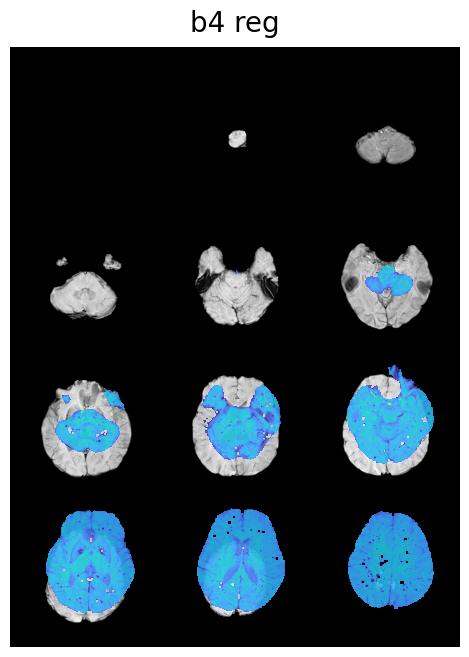

In [29]:
# without bias field correction
fixed = ants.image_read(p1)#.resample_image((128,128,35), 1, 0)
moving = ants.image_read(p14)#.resample_image((128,128,8), 1, 0)
fixed.plot(overlay=moving, title="b4 reg", axis=2)


In [30]:
mov_mask = ants.image_read(p14_seg)
mytx = ants.registration(fixed=fixed, moving=moving, moving_mask=mov_mask, type_of_transform="SyN")

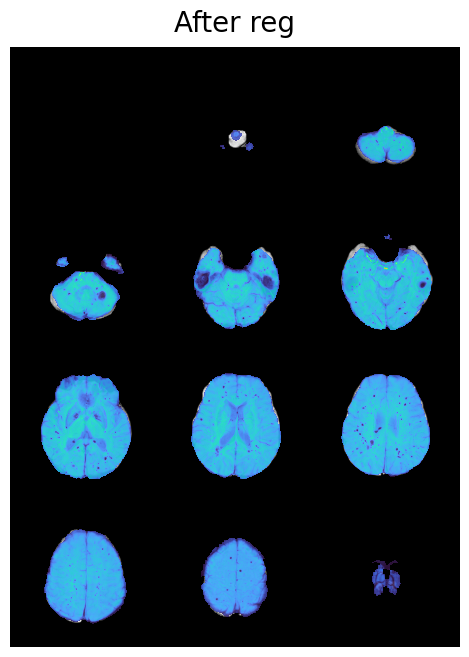

In [31]:
# overlap check
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving, title='After reg', axis=2)

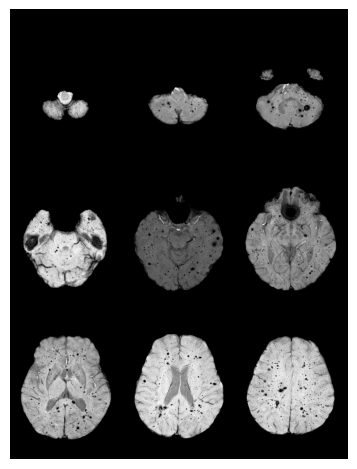

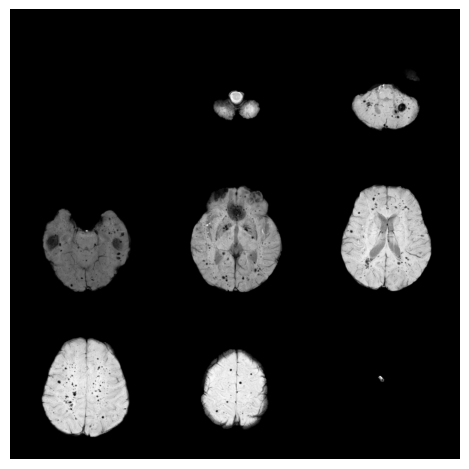

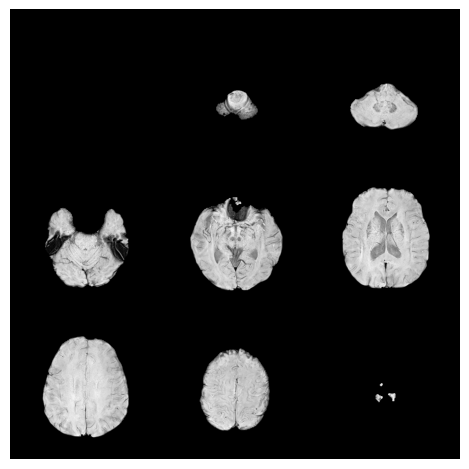

In [32]:
# comparison
moving.plot(axis=2, nslices=9, ncol=3)
warped_moving.plot(axis=2, nslices=9, ncol=3)
fixed.plot(axis=2, nslices=9, ncol=3)

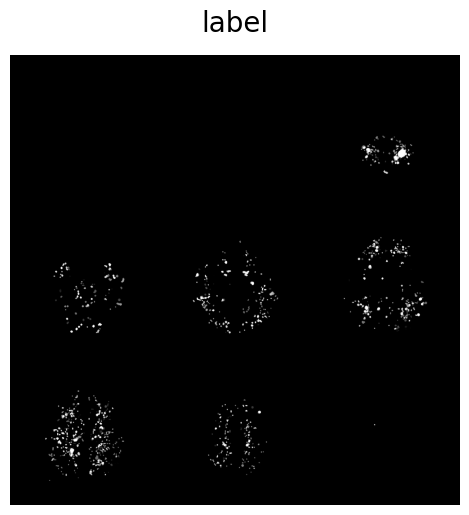

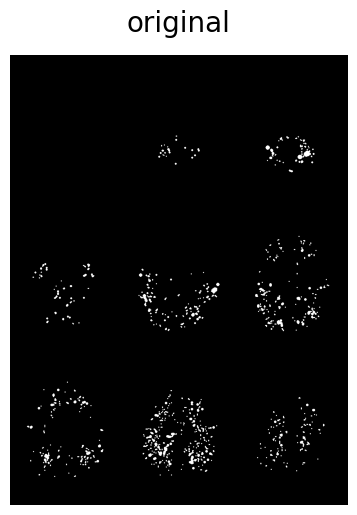

In [33]:
# apply to label as well
label = ants.apply_transforms(fixed=fixed, moving=mov_mask, transformlist=mytx['fwdtransforms'])
label.plot(axis=2, title="label", nslices=9, ncol=3)
mov_mask.plot(axis=2, nslices=9, ncol=3, title="original")

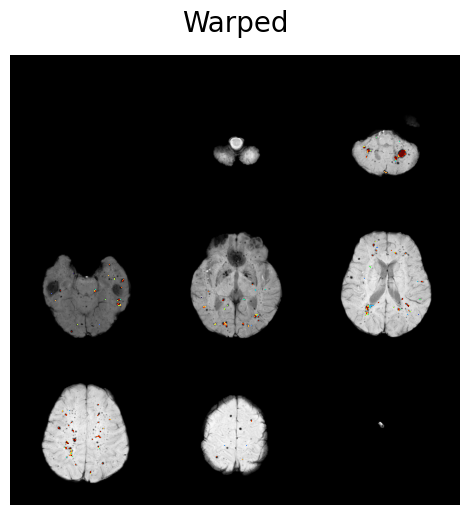

In [35]:
# warped result and warped label overlap test
warped_moving.plot(overlay=label, axis=2, title="Warped", ncol=3, nslices=9)